In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
from pathlib import Path
import dask
import yaml
import os
import utils
import warnings
import gc
import textwrap
warnings.filterwarnings('ignore')

### INPUTS specified by user

In [36]:
# case directory location
casedir="/glade/campaign/cesm/cesmdata/cseg/runs/cesm2_0/b.e30_alpha07b_dev.BHISTC_LTso.ne30_t232_wgx3.214/"

# case short name (for plot titles)
casetitle="214_hist"

# Project key
project='P04010022'

# Location of input4MIPS baselines
input4mips_dir="/glade/campaign/cgd/cas/islas/python_savs/CESM_forcings_check/input4MIPS/"

# Master list of emissions from input4MIPS
masterlist = 'emissions_master_list.yaml'
with open('emissions_master_list.yaml') as f:
    masterlist = yaml.safe_load(f)

### Set up dask cluster

In [3]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
dask.config.set({"distributed.scheduler.worker_saturation":1.0})
dask.config.set({"optimization.fuse.active": False})
dask.config.set({
    "distributed.worker.memory.target": 0.6,
    "distributed.worker.memory.spill": 0.7,
    "distributed.worker.memory.pause": 0.8,
    "distributed.worker.memory.terminate": 0.95,
})

cluster = PBSCluster(
    cores = 1,
    memory = '30GB',
    processes = 1,
    queue = 'casper',
    local_directory = '/glade/derecho/scratch/islas/dask_tmp/',
    resource_spec = 'select=1:ncpus=1:mem=30GB',
    project=project,
    walltime='02:00:00',
    interface='mgt')

# scale up
#cluster.scale(24)
cluster.adapt(minimum=1, maximum=12)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [7]:
cluster

PBSCluster(39e02bd9, 'tcp://10.18.206.69:38775', workers=1, threads=1, memory=27.94 GiB)

### Parse namelist, read emissions, convert units, and collect

In [8]:
namelist = casedir+"user_nl_cam"
with open(namelist) as f:
    emiss_lines = [ line for line in f if "->" in line ]
emiss_lines = [ line for line in emiss_lines if "num" not in line and "contvolcano" not in line]

species_list=[]
subspecies_list=[]
sector_list=[]
dat_list=[]

for iline in emiss_lines:
    file = iline.split("->")[1].strip(" ,'\n\"")
    species = iline.split("->")[0]
    species = species.replace("ext_frc_specifier","").replace("=","").replace(" ","").replace("'","")
    species = species.replace("srf_emis_specifier","").replace("=","").replace(" ","").replace("'","")
    
    if "*" in file:
        file= file.split("*")[1]
    
    dat = xr.open_dataset(file,chunks={'time':240, 'altitude':1})
    sector = dat.emiss.attrs['sectors']
    subspecies = dat.emiss.attrs['standard_name']

    print('***'+species+'***')
    print(subspecies,' ',sector)
    
    dat_gm = utils.convert_molecules_to_tg(dat, 'emiss')
    dat_gm = utils.calcannualmean(dat_gm).load()

    species_list.append(species)
    subspecies_list.append(subspecies)
    sector_list.append(sector)
    dat_list.append(dat_gm)

***bc_a4***
BC_em_AIR_anthro
you have altitudes
***SO2***
SO2_em_AIR_anthro
you have altitudes
***so4_a1***
Energy + Industrial
you have altitudes
***bc_a4***
Agriculture + Energy + Industrial + Transportation + Residential_Commercial_Other + Solventsproductionandapplication + Waste + InternationalShipping
***bc_a4***
BCsmoothed
***pom_a4***
Agriculture + Energy + Industrial + Transportation + Residential_Commercial_Other + Solventsproductionandapplication + Waste + InternationalShipping
***pom_a4***
OCsmoothed
***so4_a1***
Agriculture + Solventsproductionandapplication + Waste + InternationalShipping
***so4_a2***
Transportation + Residential_Commercial_Other
***so4_a1***
SO2smoothed
***SO2***
Agriculture + Energy + Industrial + Transportation + Residential_Commercial_Other + Solventsproductionandapplication + Waste + InternationalShipping
***SO2***
SO2smoothed
***SOAE***
C5H8smoothed
***SOAE***
C6H6smoothed
***SOAE***
Agriculture + Energy + Industrial + Transportation + Residential_Co

### Set up the plot locations

In [9]:
x1, x2, y1, y2 = utils.setup_plot_locs()

### Looping over the sectors/species/subspecies in the master list

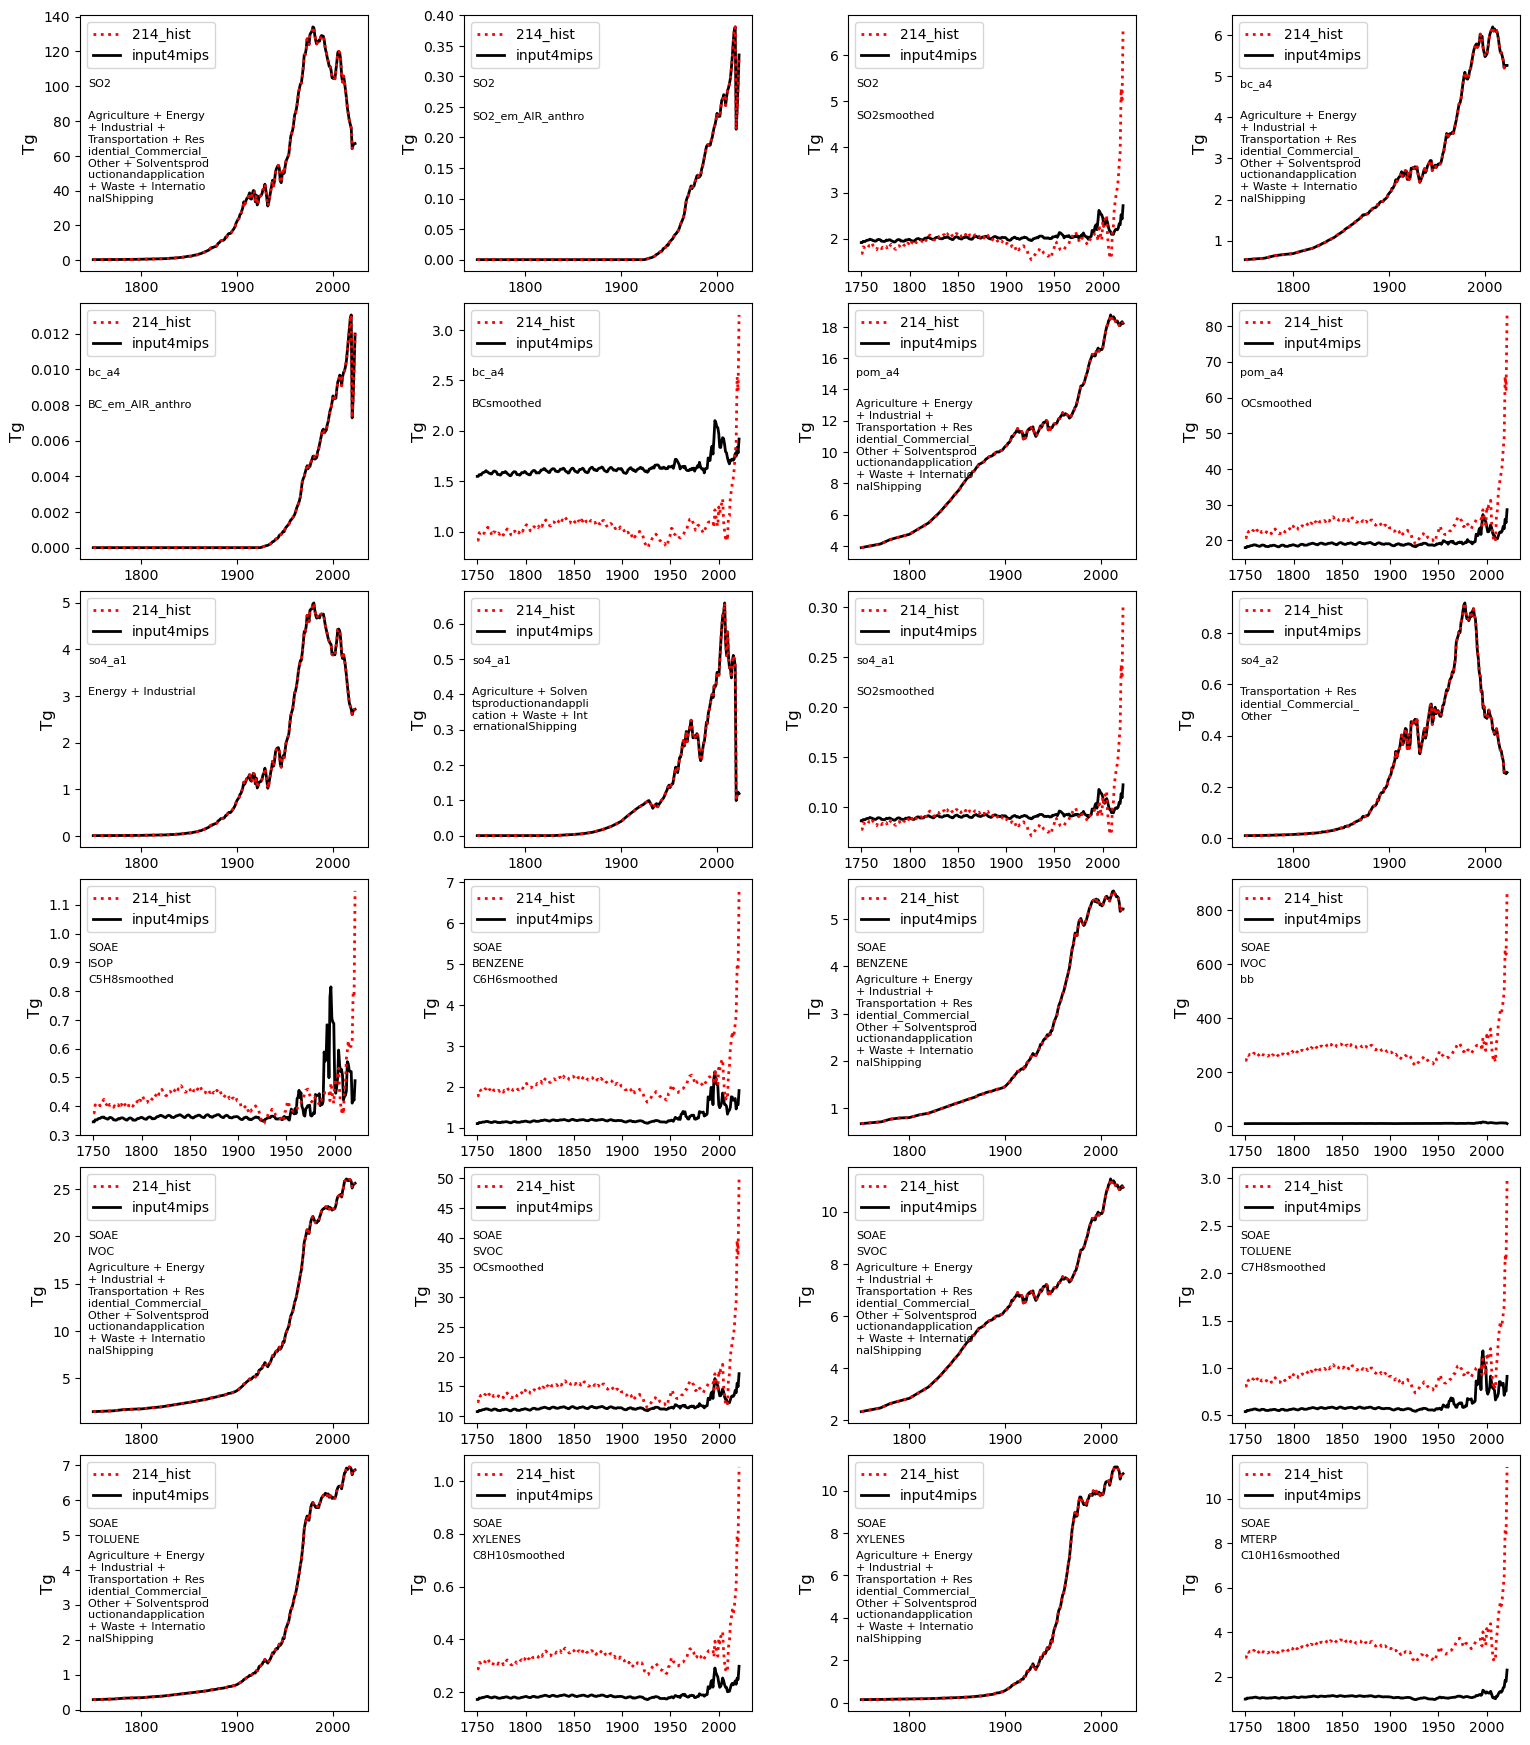

In [40]:
fig = plt.figure(figsize=(16,32))
count=0

covered=[] # List of inputs that have been covered by looping over the master list
for species, info in masterlist["species"].items():
    for sector in info["sectors"]:
        sector_filename = sector['name'].replace(" + ","_")
        sector_name = sector['name']

        # Figure out which user_nl_cam file we're looking at

        if ('sub_species' in sector):
            subspecies = sector['sub_species']
            thisplot = [ i for i, (sp, sec, subsp) in enumerate(zip(species_list, sector_list, subspecies_list))
                            if sp == species and sec == sector_name and subsp == subspecies ]
            file = input4mips_dir+species+'_'+subspecies+'_'+sector_filename+'.nc'
        else:
            subspecies=None
            thisplot = [ i for i, (sp, sec) in enumerate(zip(species_list, sector_list))
                       if sp == species and sec == sector_name ]
            file = input4mips_dir+species+'_'+sector_filename+'.nc'

        # Read in the input4mips file
        input4mips_dat = xr.open_dataset(file).emiss
        
        # If this species and sector exists in the user_nl_cam file, compare them
        if (len(thisplot) == 1):
            thisplot = thisplot[0]
            ax = utils.plot_the_plot(fig, dat_list[thisplot], species, sector_name, x1[count],x2[count],y1[count],y2[count],
                               input4mips = input4mips_dat, mylabel=casetitle, subspecies=subspecies)
            covered.append(thisplot)
        else:
            sys.exit()
            ax = utils.plot_the_plot(fig, input4mips_dat*nan, species, sector_name, x1[count],x2[count],y1[count],y2[count],
                               input4mips = input4mips_dat, mylabel=casetitle)
            fig.text(x1[count] + (x2[count]-x1[count])/2., y1[count] + (y2[count]-y1[count])/2., 'MISSING', ha='center', va='center', fontsize=20, color='red')
        count=count+1

fig.savefig('./plots/plots_'+casetitle+'_in_master_list.png', bbox_inches='tight', facecolor='white')

### Looping over any extra namelist inputs that are not covered by the master list

In [41]:
fig = plt.figure(figsize=(16,32))

extra_dat = [ v for i, v in enumerate(dat_list) if i not in covered ]
extra_species = [ v for i, v in enumerate(species_list) if i not in covered ]
extra_sector = [ v for i, v in enumerate(sector_list) if i not in covered ]
extra_subspecies = [ v for i, v in enumerate(subspecies_list) if i not in covered ]

count=0
print('There are '+str(len(extra_sector))+' extra emissions not covered by the master list')

for i in np.arange(0,len(extra_sector),1):
    ax = utils.plot_the_plot(fig, extra_dat[i], extra_species[i], extra_sector[i], x1[count], x2[count], y1[count],y2[count],
                              input4mips = None, mylabel=casetitle, subspecies=extra_subspecies[i])
    count=count+1

fig.savefig('./plots/plots_'+casetitle+'_NOT_in_master_list.png', bbox_inches='tight', facecolor='white')

There are 0 extra emissions not covered by the master list


<Figure size 1600x3200 with 0 Axes>

In [98]:
cluster.close()